In [2]:
import tensorflow as tf
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.neighbors import KDTree
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsClassifier
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import operator
import scipy as sp
from sklearn import preprocessing
import json
import pandas as pd
from scipy.stats import gamma
from math import log2
from scipy.optimize import curve_fit


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_location_AT = ["/content/drive/MyDrive/DistanceClassifier/data/ATER",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATERDD",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATGEO",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATGEOGD",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATHGG",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATSF",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATSFDD",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATSticky"]

AT_original = "/content/drive/MyDrive/DistanceClassifier/data/ATOriginal"

In [155]:
data_dict = {}
for network in data_location_AT:
  df = pd.read_csv(network, sep = ' ', header = None)
  data_dict[network[47:]] = df

In [6]:
data_dict['ATER']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,35223.0,258905.0,64.0,1901966.0,631093.0,359.0,1438.0,0.0,0.0,13957063.0,6950121.5,1149374.0,10613.0,10701.0,5247.0,2156.0,10588.0,0.0,1.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34927.0,255662.0,56.0,1869481.0,623275.0,398.0,1283.0,0.0,0.0,13647797.0,6828568.0,1138929.0,9912.0,9594.0,4900.0,2022.0,11419.0,0.0,3.0,0.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34967.0,256552.0,65.0,1882504.0,626561.0,351.0,1441.0,0.0,0.0,13798744.0,6894799.5,1143167.0,10573.0,10701.0,5330.0,2106.0,10335.0,0.0,2.0,0.0,2.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35012.0,258223.0,66.0,1903187.0,637004.0,382.0,1427.0,0.0,0.0,14015135.0,7038376.5,1182312.0,10281.0,10611.0,5175.0,2166.0,11347.0,0.0,0.0,0.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35021.0,256701.0,69.0,1878882.0,626033.0,335.0,1518.0,0.0,0.0,13743441.0,6860245.5,1142749.0,11097.0,11097.0,5484.0,2100.0,9679.0,0.0,4.0,0.0,1.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,34762.0,253364.0,63.0,1843691.0,614887.0,359.0,1393.0,0.0,0.0,13397586.0,6700534.0,1117743.0,10070.0,10034.0,5141.0,2069.0,10319.0,0.0,3.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
495,34843.0,255226.0,62.0,1869917.0,624515.0,330.0,1418.0,2.0,0.0,13690197.0,6862871.0,1147650.0,10770.0,10270.0,5411.0,2106.0,9635.0,21.0,4.0,26.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,35494.0,264069.0,64.0,1962833.0,654049.0,375.0,1444.0,0.0,0.0,14577567.0,7285247.5,1212266.0,10921.0,10682.0,5375.0,2288.0,11005.0,0.0,3.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,34852.0,255494.0,69.0,1869813.0,624419.0,378.0,1491.0,0.0,0.0,13672726.0,6845517.0,1141112.0,10599.0,10930.0,5386.0,2087.0,11126.0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
data_orig = pd.read_csv(AT_original, header = None, sep = ' ')
data_orig

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,34961.0,2904700.0,23080.0,50853063.0,552868731.0,4537960.0,4681636.0,377299.0,23214.0,1.612149e+09,5.112104e+09,1.464352e+11,237190584.0,58467782.0,981858158.0,3942360.0,1.318691e+09,97837810.0,1732850.0,19911545.0,256721361.0,29801214.0,8882403.0,1935981.0,2754375.0,6390961.0,482377.0,746844.0,125895.0,39194.0


In [7]:
def NearNeigh_PL(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)  # return an array of real data's NN distance  # return an array of real data's NN distance# return an array of real data's NN distance

In [ ]:
def single_NearNeigh_PL(data_dict, orig):
    array = []
    temp_array = []
    classes = ['ATER', 'ATERDD', 'ATGEO', 'ATGEOGD', 'ATHGG', 'ATSF', 'ATSFDD', 'ATSticky']
    for label in classes:
      data = data_dict[label]
      for i in data:
        temp = (data_orig.values - i)**2
        d = np.sqrt(np.sum(temp,axis=1))
        temp_array.append(d.min)

    return temp_array

In [8]:
#find the nearest distances of the networks
nearest_dict = {}
for network in data_location_AT:
  name = network[47:] #need to splice path to get name
  nearest = NearNeigh_PL(data_dict[name].values)
  nearest_dict[name] = nearest

In [9]:
#print the last element to check if it worked
nearest_dict['ATER']

array([  8999.52144561,   6158.54284714,   3258.32242112,  13122.18199272,
         6993.28243745,  11426.66741662,   5383.59259696,   6032.82440073,
         6554.14237334,   4791.14707038,   5904.17005175,   5685.10070271,
         5761.70026989,   5640.78649215,   8354.17033583,  10902.29521706,
         8838.41033501,  11943.63848457,  12227.93077344,  10576.60286907,
         8494.65462806,   6643.1490462 ,  37404.63342956,  39665.25061058,
         8670.93662761,   7945.48733559,   6331.90232079,   8826.07789451,
        13097.99961826,  11928.89890141,   7436.52412085,   6327.93489221,
         9118.64644561,   7567.42010199,   4248.01768476,   6032.82440073,
         6880.85801336,   8986.82624735,   2841.94757165,   5853.86635054,
         8114.5208731 ,   8838.41033501,   8131.44132365,   7471.38877653,
         5353.9940465 ,   8175.73625125,   6864.62023713,   6200.43764584,
         6278.7461527 ,  11081.7912812 ,   4444.06663429,   6425.30172443,
         6799.74545479,  

In [10]:
nearest_dict['ATERDD'].shape

(500,)

# Everything below is from Shiqi's notebook

In [105]:
def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))    
    return m
def GD(x, x0, k):
    m = (4/np.pi)*np.arctan(np.tanh(k*(x-x0)))
    return m
def arctan(x, x0, k):
    m = (2/np.pi)*np.arctan(k*(x-x0))
    return m

In [89]:
def hist_plot(data_dict, suptitle, cum = False):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(2,4, figsize = (30, 12))
    ax = ax.ravel()
    f.suptitle(suptitle)
    intervals = [0,1,2,3,4,5,6,7]
    for key,value,i in zip(data_dict.keys(), data_dict.values(), intervals):
      ax[i].hist(value,edgecolor='white',bins=50, cumulative = cum, histtype="stepfilled", density = True)   ## consider specifying <bins>
      ax[i].set_title(key)
    plt.show()

In [65]:
def log_hist_plot(data_dict, suptitle, cum = False):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(2,4, figsize = (30, 12))
    ax = ax.ravel()
    f.suptitle(suptitle)
    intervals = [0,1,2,3,4,5,6,7]
    for key,value,i in zip(data_dict.keys(), data_dict.values(), intervals):
      ax[i].hist(np.log(value),edgecolor='white',bins=50, cumulative = cum)   ## consider specifying <bins>
      ax[i].set_title(key)
    plt.show()

In [119]:
def plot_empirical_CDF(data, Density):
    fig = plt.figure()
    h = plt.hist(data,bins=len(data),density=Density,cumulative=True,histtype='stepfilled')    # bins set to equal to # of empirical data
    x = h[1][:-1]
    y = h[0]
    plt.close(fig)
    return x,y

def curve_fitter(data_NN, x, y, func):
    p0 = [np.median(data_NN),1] # this is initial guess for curve_fit()
    popt, pcov = curve_fit(f=func, xdata=x, ydata=y, p0=p0,method='lm', maxfev = 10000000)

    # parameters yielded by Curve_fit: x0, k
    print(popt)
    return popt
def sigmoid(func,x,popt):
    y = func(x, *popt)
    return y

def sig_plot(data_dict, suptitle, func):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(2,4, figsize = (30, 12))
    ax = ax.ravel()
    f.suptitle(suptitle)
    intervals = [0,1,2,3,4,5,6,7]
    for key,value,i in zip(data_dict.keys(), data_dict.values(), intervals):
      # x, y = sigmoid_calc(value, logistic)
      x, y = plot_empirical_CDF(value, True)
      popt = curve_fitter(value, x, y, func)
      y = sigmoid(func, x, popt)
      ax[i].plot(x,y)
      ax[i].set_title(key)
    plt.show()

[3.42057295e+03 3.87485384e-04]
[4.08450718e+06 3.84138419e-07]
[5.24024088e+03 5.41487662e-04]
[-1.49634930e+05  7.92704372e-06]
[7.819369e+10 1.000000e+00]
[3.80591607e+06 1.84451756e-07]
[-6.79642299e+06  4.74824307e-08]


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[6.71566290e+07 2.22563651e-08]


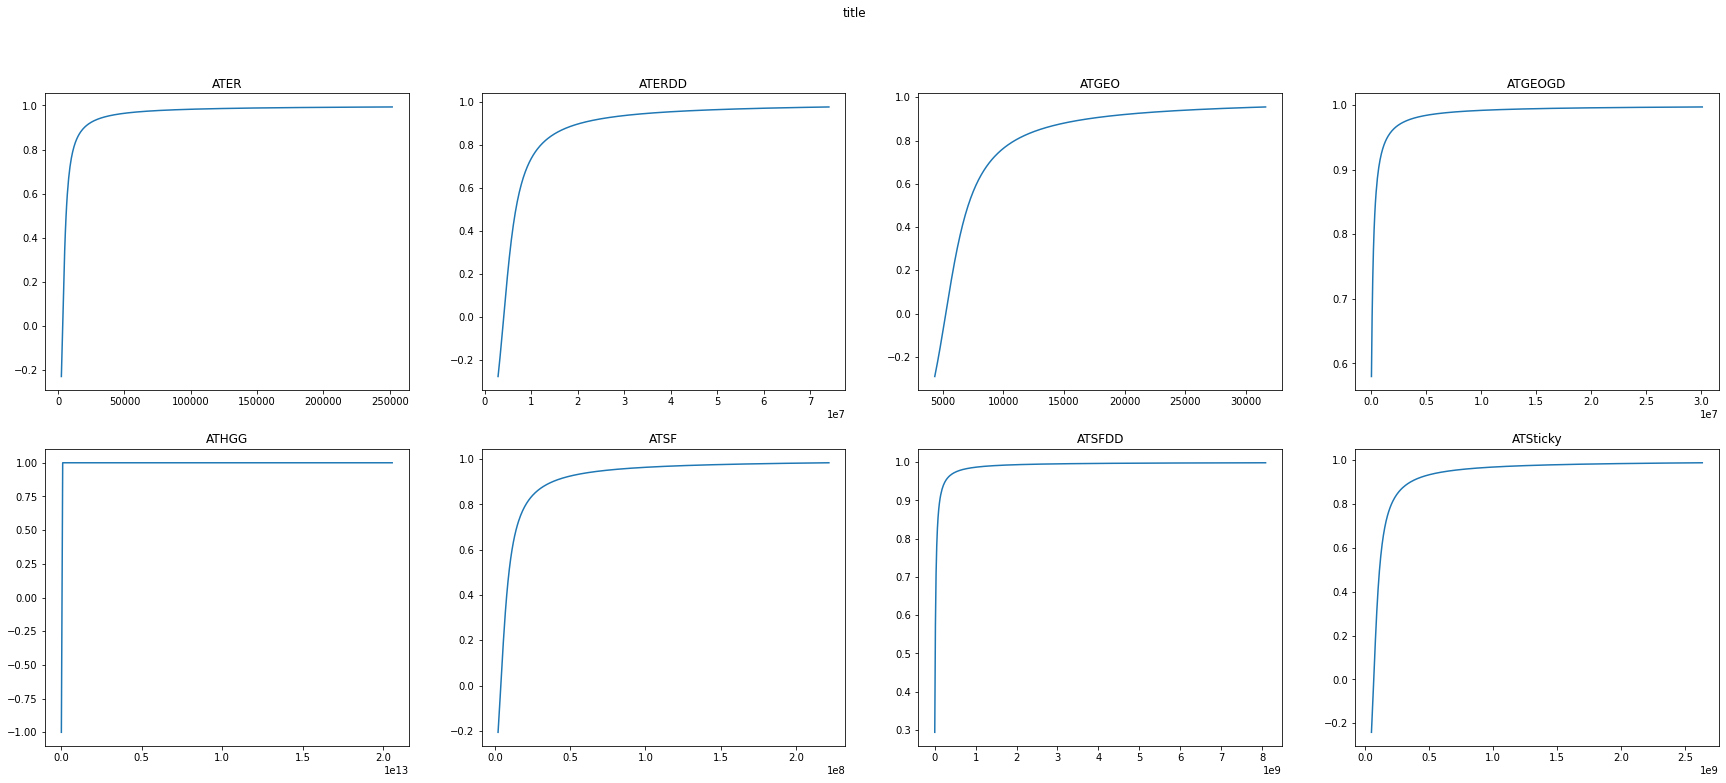

In [120]:
sig_plot(nearest_dict, 'title', arctan)

In [199]:
array = []
temp_array = []
classes = ['ATER', 'ATERDD', 'ATGEO', 'ATGEOGD', 'ATHGG', 'ATSF', 'ATSFDD', 'ATSticky']
for label in classes:
  data = data_dict[label].values
  for i in data:
    temp_array.append(np.linalg.norm(i-data_orig.values))
  array.append(temp_array)
  temp_array = []

def smallest_in_arr(euclid_list):
  small_arr = []
  smallest = 1e13;
  for array in euclid_list:
    small_arr.append(min(array))
  return small_arr

nearest_orig = smallest_in_arr(array)

In [201]:
temp1 = [3.42057295e+03, 4.08450718e+06,5.24024088e+03,-1.49634930e+05,-1.49634930e+05, 3.80591607e+06, -6.79642299e+06,6.71566290e+07 ]
temp2 = [3.87485384e-04, 3.84138419e-07, 5.41487662e-04, 7.92704372e-06, 1.000000e+00, 1.84451756e-07, 4.74824307e-08, 2.22563651e-08]

p_values = []
for i,j,k in zip(temp1, temp2, nearest_orig):
  print(arctan(k, i, j))

0.999999988788554
0.9999886736487531
0.9999999919772458
0.999999451952383
0.9999999999639252
0.999975653333195
0.999891484874022
0.9995233391111131


In [18]:
 def plot_sigmoid(data,Density, func, param):
    f, ax = plt.subplots(1,1,figsize=(10,8))
    h = ax.hist(data,bins=499,density=Density,edgecolor='white',cumulative=True,histtype='step')
    x = h[1][:-1]
    y = h[0]

    y2 = func(x,*param)    # by func curve_fit
    ax.set_yscale('log')
    ax.plot(x[:-100],1-y[:-100],color='g',label='1-empirical')
    ax.scatter(x[:])
    ax.plot(x,1-y2,color='y',label='1-sigmoid')
    ax.legend(loc='upper left')
    plt.show()
    return x,y,y2

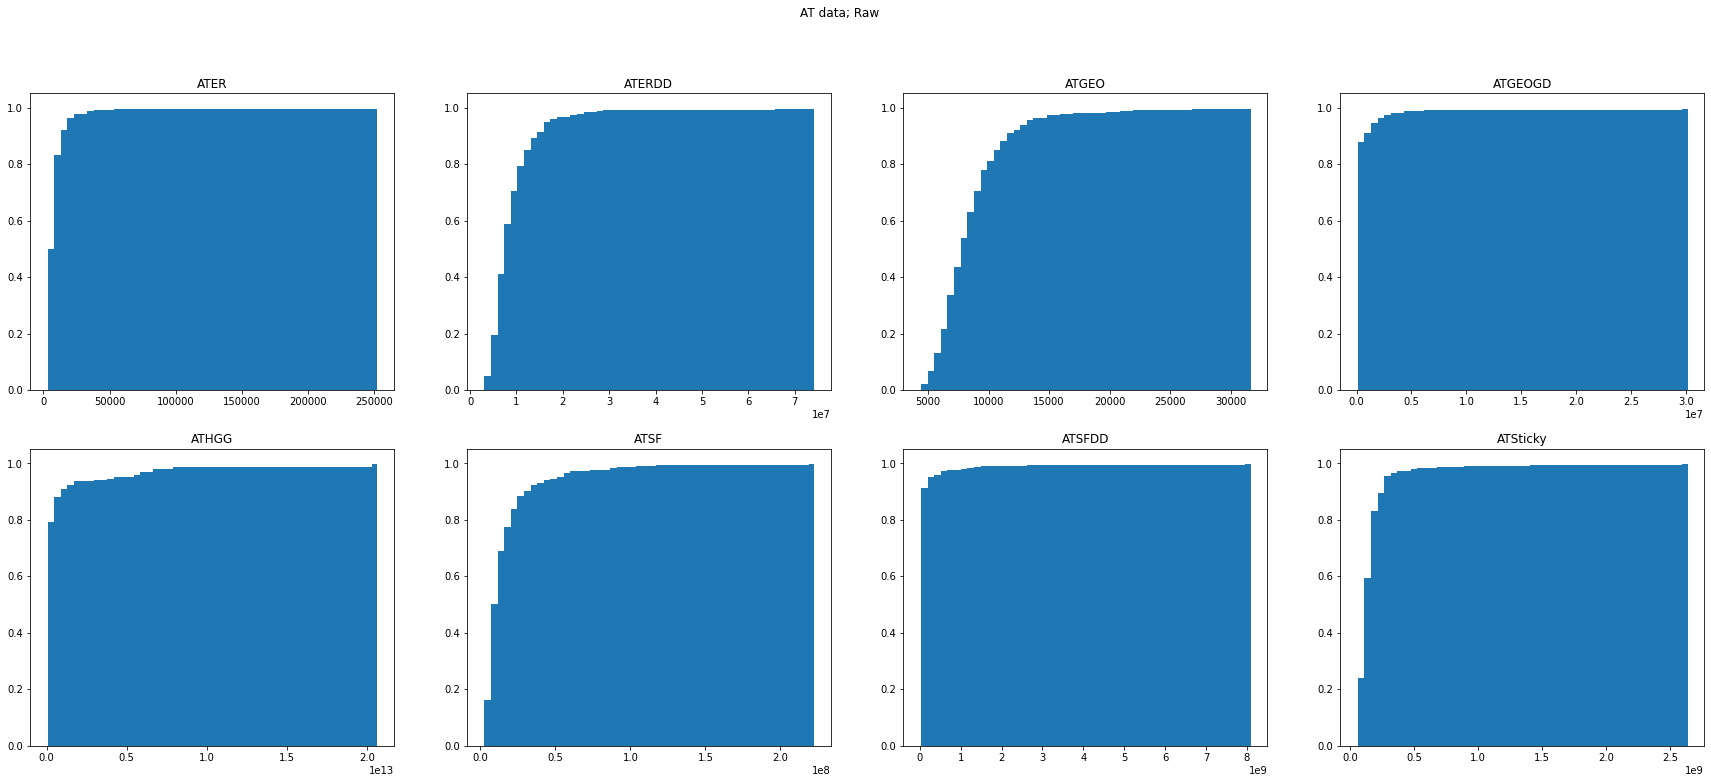

In [90]:
hist_plot(nearest_dict, 'AT data; Raw', cum = True)
plt.show()

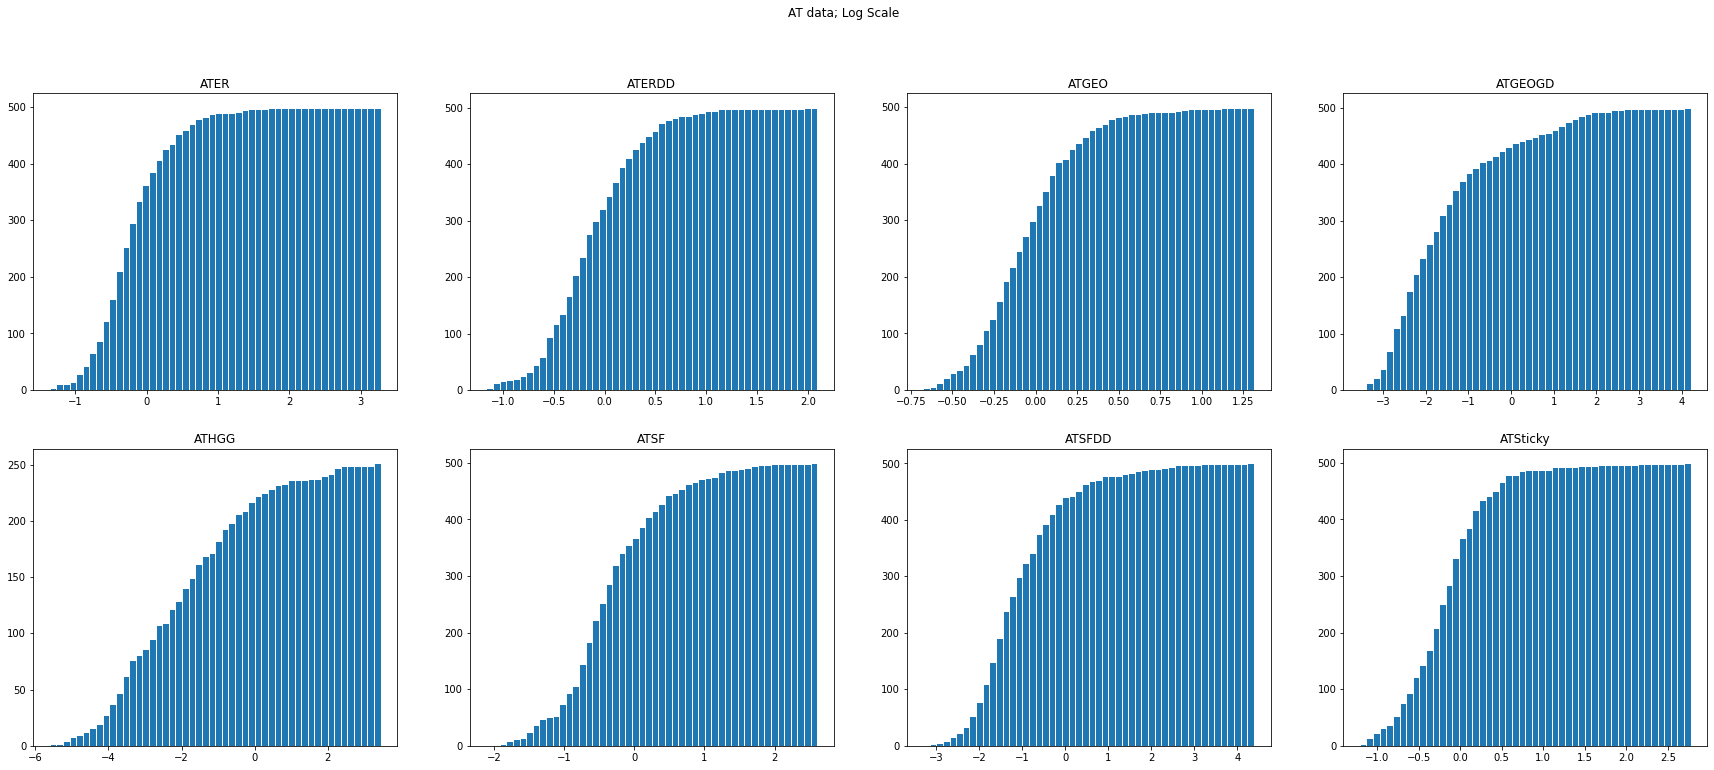

In [66]:
log_hist_plot(nearest_dict, 'AT data; Log Scale', cum = True)
plt.show()